## Testing SMILES hashing

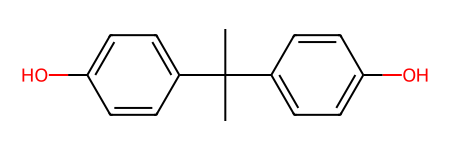

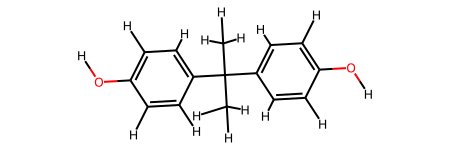

In [1]:
from rdkit import Chem
from polymerist.monomers import specification


smi = 'Oc1ccc(cc1)C(c2ccc(O)cc2)(C)C'
mol = Chem.MolFromSmiles(smi, sanitize=True)

exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
exp_mol = Chem.MolFromSmiles(exp_smi, sanitize=False)

display(mol)
display(exp_mol)

In [2]:
help(Chem.CanonSmiles)

Help on function CanonSmiles in module rdkit.Chem:

CanonSmiles(smi, useChiral=1)



In [3]:
from polymerist.genutils.textual.encoding import hash_to_alphanumeric

for atom in exp_mol.GetAtoms():
    newsmi = Chem.MolToSmiles(exp_mol, rootedAtAtom=atom.GetIdx(), canonical=True)
    print(newsmi, hash_to_alphanumeric(newsmi))

    canonsmi = Chem.CanonSmiles(newsmi)
    print(canonsmi, hash_to_alphanumeric(canonsmi))
    print('-'*50)

[H]OC1=C([H])C([H])=C(C(C2=C([H])C([H])=C(O[H])C([H])=C2[H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1[H] frT-EwYcB0R8MQRjR0Jrzw
CC(C)(c1ccc(O)cc1)c1ccc(O)cc1 AJ_WeVjckDG-Xvc_c7BPJg
--------------------------------------------------
O([H])C1=C([H])C([H])=C(C(C2=C([H])C([H])=C(O[H])C([H])=C2[H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1[H] pJc0pwgbefDJykIFPhDMKg
CC(C)(c1ccc(O)cc1)c1ccc(O)cc1 AJ_WeVjckDG-Xvc_c7BPJg
--------------------------------------------------
C1(O[H])=C([H])C([H])=C(C(C2=C([H])C([H])=C(O[H])C([H])=C2[H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1[H] -nFbU-zNKf7OGFLE_4_N7w
CC(C)(c1ccc(O)cc1)c1ccc(O)cc1 AJ_WeVjckDG-Xvc_c7BPJg
--------------------------------------------------
C1([H])=C(O[H])C([H])=C([H])C(C(C2=C([H])C([H])=C(O[H])C([H])=C2[H])(C([H])([H])[H])C([H])([H])[H])=C1[H] UQ3hbM3nGyglmzUfhg_KLQ
CC(C)(c1ccc(O)cc1)c1ccc(O)cc1 AJ_WeVjckDG-Xvc_c7BPJg
--------------------------------------------------
[H]C1=C(O[H])C([H])=C([H])C(C(C2=C([H])C([H])=C(O[H])C([H])=C2[H])(C([

# Reaction-related development

## Loading reference reaction templates and test reactants

In [4]:
import json
from pathlib import Path
from polymerist.rdutils.reactions import reactions


# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as rxnfile: # load table of functional group for each reaction
    rxn_groups = json.load(rxnfile)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

with (RXN_FILES_DIR / 'test_reactants.json').open('r') as smifile:
    test_reactant_smiles = json.load(smifile)
    test_reactants = {
        rxn_name : tuple(Chem.MolFromSmiles(smi, sanitize=False) for smi in smi_tup)
            for rxn_name, smi_tup in test_reactant_smiles.items()
    }

## Developing more robust IBIS which can handle rings

In [ ]:
import pandas as pd
import networkx as nx
from rdkit import Chem

from polymerist.rdutils.rdtypes import RDMol
from polymerist.rdutils.rdgraphs import rdmol_to_networkx
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights
from polymerist.rdutils.reactions import reactors, reactions, fragment

### Load rxn reference data

In [ ]:
df = pd.read_csv(PROC_DATA_DIR / 'monomer_data_MASTER.csv', index_col=[0,1])
frames_by_mech = {
    mechanism : df.xs(mechanism)
        for mechanism in df.index.unique(level=0)
}

### Individual reaction

In [ ]:
from polymerist.monomers import specification
from polymerist.rdutils.rdkdraw import set_rdkdraw_size
set_rdkdraw_size(300, 3/2)


# mech = 'polyurethane_isocyanate'
mech = 'polyamide'
mech = 'polyurethane_nonisocyanate'
mech = 'polyester'
mech = 'polycarbonate_phosgene'
mech = 'polyimide'
# mech = 'vinyl'

frame = frames_by_mech[mech]
row = frame.iloc[3]
rxn = rxns[mech]
reactor = reactors.PolymerizationReactor(rxn)
display(rxn)

reactants = []
for index in range(2):
    smi = row[f'smiles_monomer_{index}']
    exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smi, sanitize=False)
    display(mol)

    reactants.append(mol)

In [ ]:
set_rdkdraw_size(500)

products = reactor.react(reactants)
for product in products:
    Chem.SanitizeMol(product, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    display(product)

In [ ]:
G = rdmol_to_networkx(product)

elem_colors = {
    'C' : 'gray',
    'O' : 'red',
    'N' : 'blue',
    'H' : 'green',
    'Cl' : 'purple'
}

nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=[elem_colors[symbol] for symbol in nx.get_node_attributes(G, 'symbol').values()],
    with_labels=True
)

In [ ]:
S = G.subgraph(nx.get_node_attributes(G, 'molRxnRole').keys())
# S = G.subgraph(i for i, symbol in nx.get_node_attributes(G, 'atomic_num').items() if symbol > 1)

pos = nx.spring_layout(S)
nx.draw(
    S,
    pos=pos,
    node_color=[elem_colors[symbol] for symbol in nx.get_node_attributes(S, 'symbol').values()],
    with_labels=True
)

edge_labels = { # label by RDKit bond number
    (u, v) : data['idx']
        for u, v, data in S.edges(data=True)
}
# edge_labels = { # label by distint chains in chain decomposition
#     (u, v) : i
#         for i, chain in enumerate(nx.chain_decomposition(S)) 
#             for u, v in chain
# }
list(nx.chain_decomposition(S))
_ = nx.draw_networkx_edge_labels(
    S,
    pos=pos,
    edge_labels=edge_labels
)

In [ ]:
nx.get_node_attributes(S, 'was_dummy').keys(), nx.get_node_attributes(S, 'molRxnRole').keys()

In [ ]:
from itertools import combinations
from polymerist.genutils.iteration import sliding_window

node_pairs_to_edges = lambda pairs : [S.edges[*edge]['idx'] for edge in pairs]


bridges = set(node_pairs_to_edges(nx.bridges(S)))
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here
new_bond_ids = {i for i in rxn.product_info_maps[0].new_bond_ids_to_map_nums}

for bh_id_pair in combinations(former_bh_ids, 2):
    path_edges = node_pairs_to_edges(nx.utils.pairwise(nx.shortest_path(S, *bh_id_pair)))
    print(bh_id_pair, path_edges, set.intersection(set(path_edges), bridges))

In [ ]:
from openff.interchange import Interchange

In [ ]:
new_bond_ids

In [ ]:
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here

In [ ]:

bridge_edge_ids = [G.edges[*edge]['idx'] for edge in bridges]
new_edge_ids = [i for i in rxn.product_info_maps[0].new_bond_ids_to_map_nums]
former_bh_ids = nx.get_node_attributes(S, 'was_dummy').keys() # not checking for heavies here

bh_paths = {}
bh_bridges = {}
for bh_id_pair in combinations(former_bh_ids, 2):
    paths = [
        [S.edges[*path_edges]['idx'] for path_edges in path]
            for path in nx.all_simple_edge_paths(S, *bh_id_pair) 
    ]
    bh_paths[bh_id_pair] = paths

    


In [ ]:

class CutBridgesNearReactingAtoms(reactors.IBIS):
    '''IBIS which looks for bridges occurring within the activate portion of a reaction product to minimize the number of cuts made'''
    def locate_intermonomer_bonds(self, product: RDMol, product_info: reactors.RxnProductInfo) -> reactors.Generator[int, None, None]:
        return super().locate_intermonomer_bonds(product, product_info)

In [ ]:
def test():
    former_bh_ids = [atom_id for match in prod.GetSubstructMatches(fragment.HEAVY_FORMER_LINKER_QUERY) for atom_id in match]
    bridge_bond_ids = {prod.GetBondBetweenAtoms(*pair).GetIdx() for pair in bridges}
    print(bridge_bond_ids)
    new_bond_ids = set(rxn.product_info_maps[0].new_bond_ids_to_map_nums)

    new_bridge_bond_ids = set.intersection(bridge_bond_ids, new_bond_ids)
    if new_bridge_bond_ids:
        yield from new_bridge_bond_ids
    else:
        for bh_id_pair in combinations(former_bh_ids, 2):
            for path in nx.all_simple_edge_paths(S, *bh_id_pair):
                path_edges = set(S.edges[*pair]['idx'] for pair in path)
                if set.intersection(path_edges, new_bond_ids):
                    yield from set.intersection(path_edges, bridge_bond_ids)

In [ ]:
BUFFER = '='*10
for i, (dimers, frags) in enumerate(reactor.propagate(reactants)):
    print(f'{BUFFER}STEP {i}{BUFFER}')
    for j, dim in enumerate(dimers):
        print(f'Dimer {i}-{j}')
        display(dim)
    bins = []
    for j, frag in enumerate(frags):
        print(f'Fragment {i}-{j}')
        display(frag)

## Playing with Stereo detection/enumeration

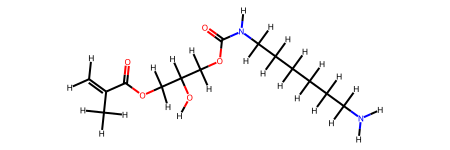

In [17]:
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.reactions import reactions, reactors


rxn_name = 'polyurethane_nonisocyanate'
rxn = rxns[rxn_name]
reactants = test_reactants[rxn_name]

reactor = reactors.PolymerizationReactor(rxn)
products = reactor.react(reactants)
product = molwise.clear_atom_map_nums(products[0])
display(product)

In [18]:
print(Chem.StereoType.names)
print(Chem.ChiralType.names)
print(Chem.BondStereo.names)
print(Chem.BondDir.names)

{'Unspecified': rdkit.Chem.rdchem.StereoType.Unspecified, 'Atom_Tetrahedral': rdkit.Chem.rdchem.StereoType.Atom_Tetrahedral, 'Atom_SquarePlanar': rdkit.Chem.rdchem.StereoType.Atom_SquarePlanar, 'Atom_TrigonalBipyramidal': rdkit.Chem.rdchem.StereoType.Atom_TrigonalBipyramidal, 'Atom_Octahedral': rdkit.Chem.rdchem.StereoType.Atom_Octahedral, 'Bond_Double': rdkit.Chem.rdchem.StereoType.Bond_Double, 'Bond_Cumulene_Even': rdkit.Chem.rdchem.StereoType.Bond_Cumulene_Even, 'Bond_Atropisomer': rdkit.Chem.rdchem.StereoType.Bond_Atropisomer}
{'CHI_UNSPECIFIED': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'CHI_TETRAHEDRAL_CW': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, 'CHI_TETRAHEDRAL_CCW': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, 'CHI_OTHER': rdkit.Chem.rdchem.ChiralType.CHI_OTHER, 'CHI_TETRAHEDRAL': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL, 'CHI_ALLENE': rdkit.Chem.rdchem.ChiralType.CHI_ALLENE, 'CHI_SQUAREPLANAR': rdkit.Chem.rdchem.ChiralType.CHI_SQUAREPLANAR, 'CHI_TRIGONAL

In [19]:
for atom in product.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetChiralTag())

0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED
0 CHI_UNSPECIFIED


In [20]:
from rdkit.Chem.rdchem import StereoType, ChiralType, BondStereo, BondDir
from polymerist.rdutils.labeling import molwise

for stereo_info in Chem.FindPotentialStereo(product):
    print(f'  Type: {stereo_info.type}, Which: {stereo_info.centeredOn}, Specified: {stereo_info.specified}, Descriptor: {stereo_info.descriptor} ')
    print(stereo_info.centeredOn, next(molwise.map_nums_by_atom_ids(product, stereo_info.centeredOn)))

  Type: Atom_Tetrahedral, Which: 1, Specified: Unspecified, Descriptor: NoValue 
1 0


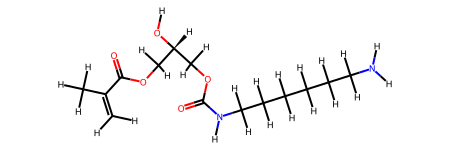

[H]O[C@@]([H])(C([H])([H])OC(=O)C(=C([H])[H])C([H])([H])[H])C([H])([H])OC(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])[H]


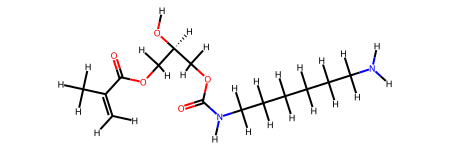

[H]O[C@]([H])(C([H])([H])OC(=O)C(=C([H])[H])C([H])([H])[H])C([H])([H])OC(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])[H]


In [21]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem.AllChem import EmbedMolecule

options = StereoEnumerationOptions(
    onlyUnassigned=False
)

Chem.AssignStereochemistry(product, flagPossibleStereoCenters=True)
Chem.FindPotentialStereoBonds(product)

for isomer in EnumerateStereoisomers(product):
    display(isomer)
    print(Chem.MolToSmiles(isomer, isomericSmiles=True))